In [1]:
import pprint
import torch
import numpy as np

In [2]:
import pickle
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
try:
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
except:
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
print(f"Using {device} as device")

Using cuda as device


In [4]:
from hyperstyle_utils import *

Using cuda as device


In [5]:
G = load_hyperstyle()

Loading HyperStyle from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt
Loading pretrained W encoder...
Loading ReStyle e4e from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/restyle/00005_snapshot_1200/checkpoints/best_model.pt
Model successfully loaded!


In [12]:
sku = "02R21C00O-Q11"
latent, weight_delta = load_generator_inputs(sku)
gen, img = generate_hyperstyle(latent, weight_delta, G, return_image=True)

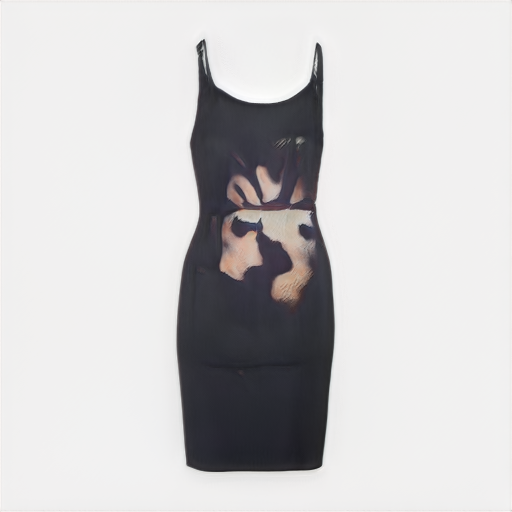

In [7]:
img